In [1]:
import torch as pt
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD
import ignite.metrics as metrics

In [2]:
from torchvision.datasets import FashionMNIST


def get_dataset():
    dataset = FashionMNIST('./data/fashion_mnist', download=True)

    idx = (dataset.targets==3) | (dataset.targets==5)
    dataset.targets = dataset.targets[idx]
    dataset.data = dataset.data[idx]
    return dataset 

In [3]:
df = get_dataset()

In [4]:
df.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
test_mask = (df.test_labels == 3) |( df.test_labels == 5)
train_mask = (df.train_labels == 3) |( df.train_labels == 5)

/Users/janix4000/miniconda3/envs/mro/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/Users/janix4000/miniconda3/envs/mro/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
train_data = df.train_data[train_mask][:10_000]
train_labels = pt.Tensor.float(df.train_labels[train_mask][:10_000])

test_data = df.test_data[test_mask][10_000:]
test_labels = pt.Tensor.float(df.test_labels[test_mask][10_000:])

/Users/janix4000/miniconda3/envs/mro/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/janix4000/miniconda3/envs/mro/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [7]:
train_labels

tensor([3., 5., 5.,  ..., 3., 5., 3.])

In [8]:
train_labels = pt.Tensor.float( pt.where(train_labels == 3, 0.0, 1.0) )
test_labels = pt.Tensor.float( pt.where(test_labels == 3, 0.0, 1.0) )

In [9]:
def show_12(df, title):
    fig, axs = plt.subplots(3, 4, figsize=(4*3, 3*3))
    axs = np.reshape(axs, (-1))
    for ax, vec in zip(axs, df):
        ax.imshow(vec)
    fig.suptitle(f"{title}[:12]", fontsize=16)
    plt.show()

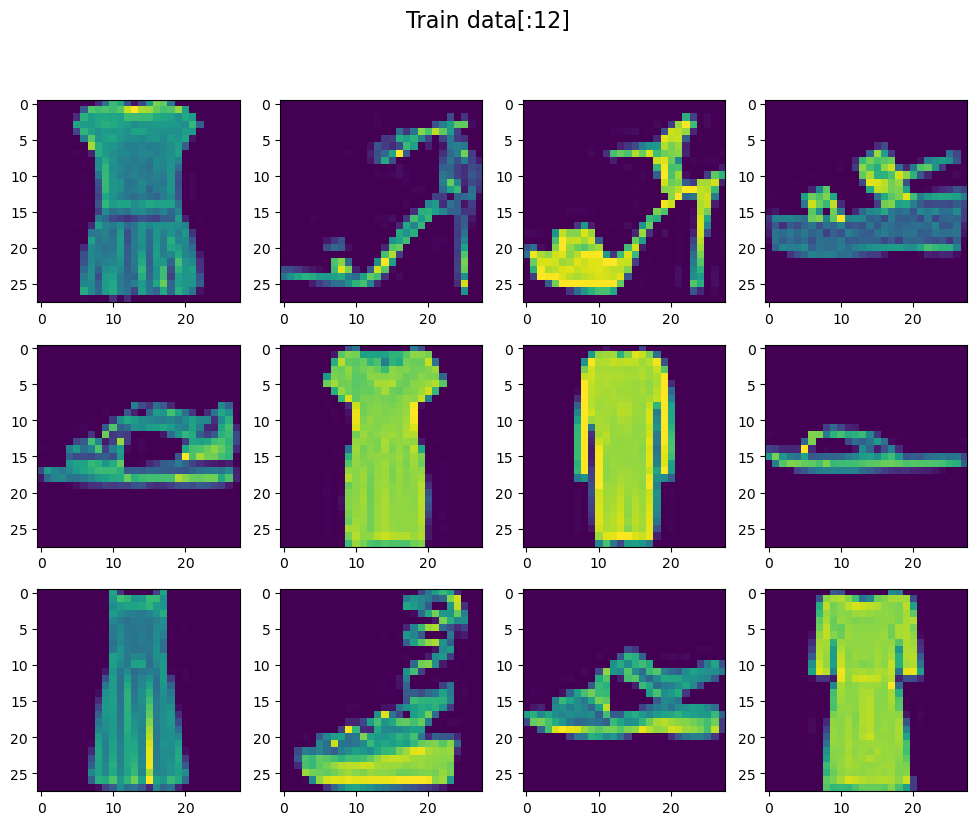

In [10]:
show_12(train_data, "Train data")

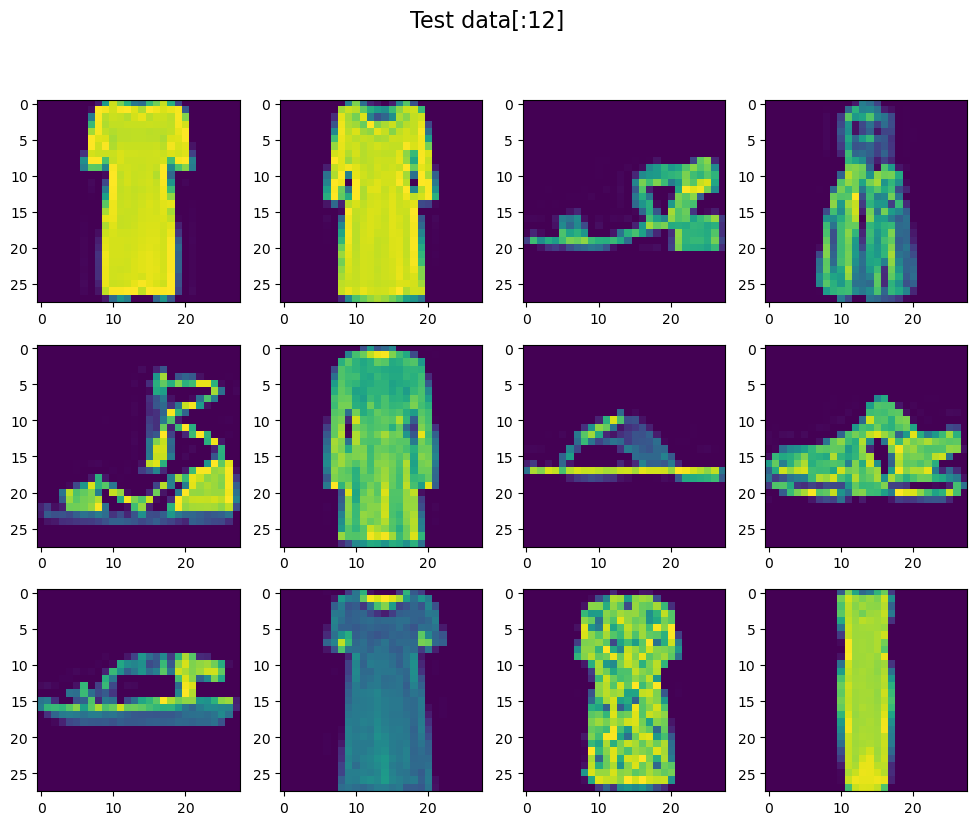

In [11]:
show_12(test_data, "Test data")

In [12]:
flat_test_data = pt.reshape(test_data, (test_data.shape[0], -1))
flat_train_data = pt.reshape(train_data, (train_data.shape[0], -1))

In [13]:
flat_test_data = pt.nn.functional.normalize(pt.Tensor.float(flat_test_data))
flat_train_data = pt.nn.functional.normalize(pt.Tensor.float(flat_train_data))

In [14]:

class NeuralNet(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.matrix = nn.Linear(n_inputs, 1, bias=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.matrix(x)
        x = self.sigmoid(x)
        return x.squeeze()
    def show_weights(self):
        plt.imshow(f.matrix.weight.reshape(28, 28).data)
        plt.show()

In [15]:
f = NeuralNet(flat_test_data.shape[1])

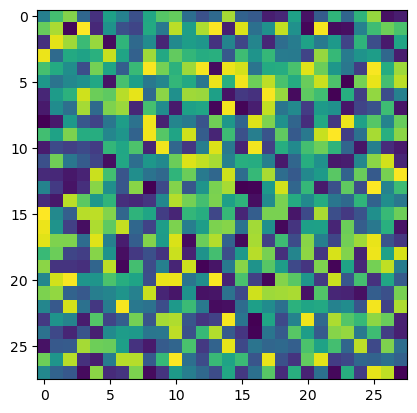

In [16]:
f.show_weights()

In [17]:
loss = nn.CrossEntropyLoss()

In [18]:
loss(f(flat_train_data), train_labels)

tensor(46170.9023, grad_fn=<DivBackward1>)

In [19]:
train_labels

tensor([0., 1., 1.,  ..., 0., 1., 0.])

In [20]:
opt = SGD(f.parameters(), lr=0.001)

In [21]:
losses = []
for _ in range(100):
    opt.zero_grad() # flush previous epoch's gradient
    loss_value = loss(f(flat_train_data), train_labels) #compute loss
    loss_value.backward() # compute gradient
    opt.step() # Perform iteration using gradient above
    losses.append(loss_value.item())

Text(0.5, 0, 'Epochs')

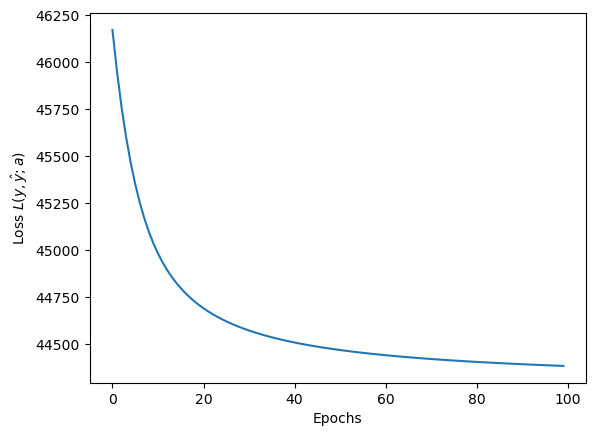

In [22]:
plt.plot(losses)
plt.ylabel('Loss $L(y,\hat{y};a)$')
plt.xlabel('Epochs')

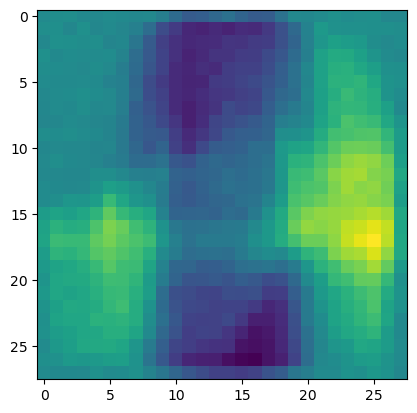

In [23]:
f.show_weights()

In [31]:
pt.where(f(flat_test_data) < 0.5, 0.0, 1.0)

tensor([0., 0., 1.,  ..., 1., 0., 1.])

In [33]:
metric = metrics.Precision()

In [39]:
y = test_labels
y_pred = pt.where(f(flat_test_data) < 0.5, 0.0, 1.0)
tp = pt.count_nonzero(y == y_pred)
precision = tp / y.shape[0]

In [40]:
precision

tensor(0.9970)